In [1]:
import numpy as np
import networkx as nx
import ndlib.models.epidemics.SIRModel as sir
from ndlib.utils import multi_runs
import ndlib.models.ModelConfig as mc
from ndlib.viz.mpl.DiffusionTrend import DiffusionTrend
from network_optimizer import *

from sklearn.cluster import SpectralClustering
from sklearn import metrics

from submodular_fun import covdiv_F
import pandas as pd 

from bokeh.io import output_notebook, show
import matplotlib.pyplot as plt
from math import *
import os

import warnings
warnings.filterwarnings("ignore")

## 5) Experiments
### 5.1) Experiment on small random graphs
In this part, the cost is constant (1 for each node selected) to simplify hyperparameter optimization.
##### 5.1.1) Hyper-parameters optimization

##### Coverage-Diversity function : $\lambda$ optimization

In [4]:
L = ['facebook_combined', ] #, 50]
k = 25
p = 0.4
r=1
Lambda = [0, 0.05, 0.1, 0.5, 1, 5, 10, 25, 50]
Res_l = np.zeros((len(Lambda), len(L)))
parameters = {'beta' : 0.01, 'gamma': 0.1, 'T': 3, 'N': 100}
j = 0
for l in L:
    i = 0
    #g=nx.relaxed_caveman_graph(l, k, p) #better models for social networks
    file = 'data/{}.txt'.format(l)
    g = nx.read_edgelist(file,create_using=nx.Graph())
    g = nx.convert_node_labels_to_integers(g)
    V = list(g.nodes)
    nbr_nodes = len(V)
    adj = nx.adjacency_matrix(g)
    budget = np.amax(np.array(adj.sum(axis=0)))
    sim = cosine_similarity(adj,adj)
    degree_cent = nx.degree_centrality(g)
    opt = Optimizer_contagion_Model(g, parameters)
    n_cluster = ceil(0.01*nbr_nodes)
    cluster = opt.get_cluster(n_cluster)
    print('cluster done')
    for lambda0 in Lambda:
        #cost = lambda S:len(S) #Constant cost
        f_sub = lambda S : covdiv_F(S, V, cluster, sim, degree_cent, lambda1=lambda0)
        S = opt.greedy_submodular(f_sub, None, budget=budget, r=r, lazy=True)
        Res_l[i][j] = opt.f_sub(S)
        print(lambda0, Res_l[i][j])
        i += 1
    j += 1
print(pd.DataFrame(Res_l))
pd.DataFrame(Res_l).to_csv("experiments/hyperparameters_opt/hyp_par_lambda.csv")

cluster done
0 780.05
0.05 782.63
0.1 782.59
0.5 772.38
1 773.56
5 763.48
10 755.79
25 754.15
50 758.25
        0
0  780.05
1  782.63
2  782.59
3  772.38
4  773.56
5  763.48
6  755.79
7  754.15
8  758.25


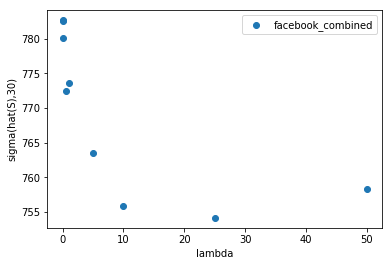

In [5]:
plt.scatter(Lambda, Res_l[:,0], label=L[0])
plt.xlabel('lambda')
plt.ylabel('sigma(hat(S),30)')
plt.legend()
plt.savefig('hyp_par_lambda.png')
plt.show()

##### Coverage-Diversity function : saturation
We assume that the optimal number of cluster the following law : $K = \alpha \times N$ with $N$ the number of nodes (the more big the network is, the more cluster there should be). What's the optimal $\alpha$ ? (Best alpha in litterature $\alpha =  0.2$ [Lin Bilmes 210])

In [ ]:
Alpha = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 1]
L = ['facebook'] 
k = 25
lambda0 = 0.1
p = 0.6
Res_a = np.zeros((len(Alpha), len(L)))
parameters = {'beta' : 0.01, 'gamma': 0.1, 'T': 4, 'N': 100}
j = 0
for l in L:
    i = 0
    #g=nx.relaxed_caveman_graph(l, k, p) #better models for social networks
    file = 'data/facebook_combined.txt'
    g = nx.read_edgelist(file,create_using=nx.Graph())
    g = nx.convert_node_labels_to_integers(g)
    V = list(g.nodes)
    nbr_nodes = len(V)
    adj = nx.adjacency_matrix(g)
    sim = cosine_similarity(adj,adj)
    degree_cent = nx.degree_centrality(g)
    budget = np.amax(np.array(adj.sum(axis=0)))
    V = list(g.nodes)
    opt = Optimizer_contagion_Model(g, parameters)
    print('cluster done')
    n_cluster = ceil(0.05*nbr_nodes)
    cluster = opt.get_cluster(n_cluster)
    for alpha in Alpha:
        print(i)
        cost = lambda S:len(S) #Constant cost
        f_sub = lambda S : covdiv_F(S, V, cluster, sim, degree_cent, lambda1=lambda0, alpha=alpha)
        S = opt.greedy_submodular(f_sub, None, budget=budget, r=5, lazy=True)
        Res_a[i][j] = opt.f_sub(S)
        i += 1
    j += 1
print(pd.DataFrame(Res_a))
pd.DataFrame(Res_a).to_csv("experiments/hyperparameters_opt/hyp_par_alpha.csv")

plt.scatter(Alpha, Res_a[:,0], label=L[0])
plt.xlabel('alpha')
plt.ylabel('sigma(hat(S),30)')
plt.legend()
plt.savefig('hyp_par_alpha.png')
plt.show()

##### Greedy-alg + Coverage-Diversity function : $r$ optimization (scability)
Litterature : $r=0.3$

In [7]:
L = ['facebook']#[1, 2, 3, 4, 8, 15] #, 20, 50]
k = 25
p = 0.4
R = [0, 0.1, 0.5, 1, 1.5, 2, 2.5, 3, 5, 10]
Res_r = np.zeros((len(R), len(L)))
lambda0 = 0.1
parameters = {'beta' : 0.01, 'gamma': 0.1, 'T': 3, 'N': 100}
j = 0
for l in L:
    i = 0
    #g=nx.relaxed_caveman_graph(l, k, p) #better models for social networks
    file = 'data/facebook_combined.txt'
    g = nx.read_edgelist(file,create_using=nx.Graph())
    g = nx.convert_node_labels_to_integers(g)
    V = list(g.nodes)
    nbr_nodes = len(V)
    adj = nx.adjacency_matrix(g)
    sim = cosine_similarity(adj,adj)
    budget = np.amax(np.array(adj.sum(axis=0)))
    degree_cent = nx.degree_centrality(g)
    V = list(g.nodes)
    opt = Optimizer_contagion_Model(g, parameters)
    n_cluster = ceil(0.01*nbr_nodes)
    cluster = opt.get_cluster(n_cluster)
    print('cluster done')
    for r in R:
        cost = lambda S:len(S) #Constant cost
        f_sub = lambda S : covdiv_F(S, V, cluster, sim, degree_cent, lambda1=lambda0)
        S = opt.greedy_submodular(f_sub, None, budget=budget, r=r, lazy=True)
        Res_r[i][j] = opt.f_sub(S)
        i += 1
    j += 1
print(pd.DataFrame(Res_r))
pd.DataFrame(Res_r).to_csv("experiments/hyperparameters_opt/hyp_par_r.csv")

cluster done
        0
0  455.55
1  572.19
2  761.53
3  785.46
4  790.40
5  793.32
6  803.56
7  797.12
8  794.56
9  802.65


In [ ]:
print(pd.DataFrame(Res_r))
plt.scatter(R, Res_r[:,0], label=L[0])
plt.xlabel('r')
plt.ylabel('sigma(hat(S),30)')
plt.legend()
plt.savefig('hyp_par_r.png')
plt.show()

##### 5.1.2) Comparison (random/covdiv/expected) [Long]

In [35]:
import time
N = [10, 50, 100, 200, 300, 400, 500]
time_sub = []
time_expected = []
score_sub = []
score_expected = []
score_random = []
parameters = {'beta' : 0.01, 'gamma': 0.1, 'T': 4, 'N': 100}
edges = np.genfromtxt('data/com-youtube.ungraph.txt', delimiter='\t')
for nbr_nodes in N:
    g = nx.Graph()
    g.add_edges_from(edges[:nbr_nodes])
    g = nx.convert_node_labels_to_integers(g)
    V = list(g.nodes)
    adj = nx.adjacency_matrix(g)
    budget = np.amax(np.array(adj.sum(axis=0))) + 1
    sim = cosine_similarity(adj,adj)
    degree_cent = nx.degree_centrality(g)
    opt = Optimizer_contagion_Model(g, parameters)
    n_cluster = ceil(0.05*len(V))
    cluster = opt.get_cluster(n_cluster)
    f_sub = lambda S : covdiv_F(S, V, cluster, sim, degree_cent, lambda1=0.1)
    
    t_start = time.time()
    S1 = opt.greedy_submodular(f_sub, None, budget=budget, r=5, lazy=True)
    time_sub.append(time.time() - t_start)
    
    t_start = time.time()
    S2 = opt.greedy_submodular(cost_fun=None, budget=budget, r=5, lazy=True)
    time_expected.append(time.time() - t_start)
    
    S3 = opt.random_select(cost_fun=None, budget=budget)
    score_sub.append(opt.f_sub(S1, N0=100))
    score_expected.append(opt.f_sub(S2, N0=100))
    score_random.append(opt.f_sub(S3, N0=100))
    print(nbr_nodes)
pd.DataFrame(np.array([score_random, score_sub, score_expected])).to_csv("experiments/comparison_youtube.csv")

10
50
100
200
300
400
500


In [40]:
print(g.nodes)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

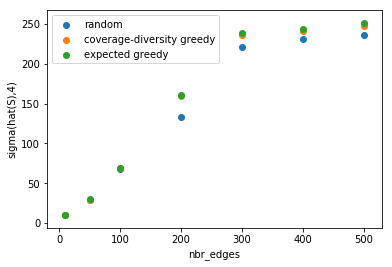

In [41]:
plt.scatter(N, score_random, label='random')
plt.scatter(N, score_sub, label='coverage-diversity greedy')
plt.scatter(N, score_expected, label='expected greedy')
plt.xlabel('nbr_edges')
plt.ylabel('sigma(hat(S),4)')
plt.legend()
plt.savefig('comparison_youtube.png')
plt.show()

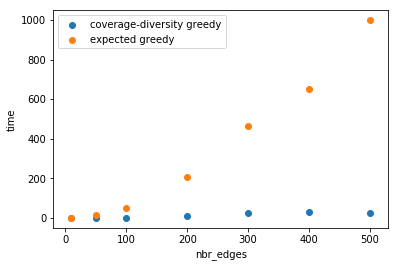

In [39]:
plt.scatter(N, time_sub, label='coverage-diversity greedy')
plt.scatter(N, time_expected, label='expected greedy')
plt.xlabel('nbr_edges')
plt.ylabel('time')
plt.legend()
plt.savefig('comparison_youtube_time.png')
plt.show()

### 5.) Experiment on real data
$\alpha=0.2$, $\lambda=0.1$, $r=5$. Budget : nbr maximal de neigbors

In [2]:
alpha = 0.01
file = 'data/facebook_combined.txt'
g = nx.read_edgelist(file,create_using=nx.Graph())
g = nx.convert_node_labels_to_integers(g)
V = list(g.nodes)
r = 5
parameters = {'beta' : 0.01, 'gamma': 0.1, 'T': 4, 'N': 50}

adj = nx.adjacency_matrix(g)
budget = np.amax(np.array(adj.sum(axis=0))) + 1
print(budget)
sim = cosine_similarity(adj,adj)
degree_cent = nx.degree_centrality(g)
opt = Optimizer_contagion_Model(g, parameters)
n_cluster = ceil(0.05*len(V))
cluster = opt.get_cluster(n_cluster)
print('cluster done')
#cost = lambda S:len(S) #Constant cost
f_sub = lambda S : covdiv_F(S, V, cluster, sim, degree_cent, lambda1=0.1)
S1 = opt.greedy_submodular(f_sub, None, budget=budget, r=r, lazy=True) #f_sub)
print('Optimization done')
S3 = opt.random_select(cost_fun=None, budget=budget)
score_covdiv = opt.f_sub(S1, N0=100)
score_rand = opt.f_sub(S3, N0=100)
print(score_covdiv, score_rand)
print(S1, S3)
pd.DataFrame(np.array([score_covdiv, score_rand])).to_csv("experiments/comparison.csv")

1046
cluster done
Optimization done
456.59 84.18
[397, 404, 582, 1319, 1067, 1046, 952, 872, 692, 631, 605, 2406, 2754, 2711, 2575, 2612, 3978, 3943, 3868, 3865, 3834, 3812, 3766, 3748, 3730, 3676, 3603, 3497, 3495, 3435, 3415, 3342, 3335, 3195, 3139, 3059, 11, 12, 335, 292, 287, 215, 210, 209, 114, 74, 43, 37, 18, 15, 1750, 4035, 1760, 1526, 1696, 1603, 1763, 1764, 1812, 1808, 1786, 1776, 1946, 1837, 1767, 3987, 4025, 4023, 4016, 4012, 4010, 2037, 2036, 2029, 2021, 881, 916, 812, 880, 551, 710, 2799, 2670, 2911, 2421, 353, 2357, 2910, 3725, 3751, 3930, 3620, 3821, 3965, 3885, 3822, 3894, 3764, 748, 662, 1175, 762, 1240, 719, 1507, 1044, 2786, 756, 153, 1339, 305, 267, 3393, 1506, 138, 35, 70, 216, 154, 160, 52, 255, 90, 286, 47, 282, 33, 233, 3710, 2006, 3859, 2553, 2661, 3888, 3866, 3950, 3274, 183, 205, 241, 145, 256, 42, 244, 316, 1820, 234, 279, 1543, 1599, 1562, 1541, 1895, 1844, 1920, 1793, 1746, 1623, 3986, 4008, 1889, 4036, 4029, 4030, 3990, 1894, 1986, 2005, 1789, 4032, 4003,

In [3]:
print(opt.f_sub(S1, N0=500))

454.892


In [3]:
I = [423,
 2439,
 1942,
 3139,
 1202,
 2997,
 1612,
 119,
 55,
 2463,
 3375,
 908,
 3250,
 179,
 89,
 1790,
 1048,
 702,
 3252,
 686,
 3459,
 2738,
 2783,
 1933,
 2291]
print(opt.f_sub(I,N0=100))

98.1


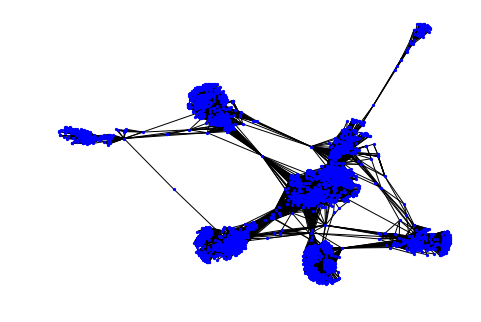

In [18]:
nx.draw(g, with_labels=False, node_size=5, node_color='blue')
plt.savefig('facebook_graph.png')

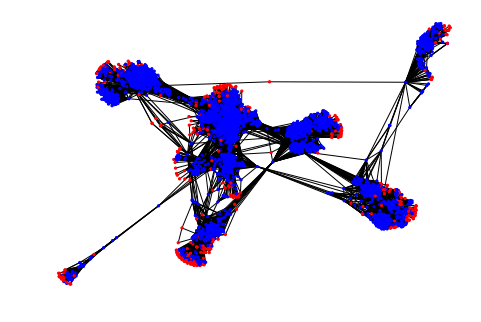

In [5]:
color = []
for x in V:
    if x in S1:
        color.append('red')
    else:
        color.append('blue')
nx.draw(g, with_labels=False, node_size=5, node_color=color)
plt.savefig('facebook_graph_fcovdiv.png')
plt.show()

In [ ]:
S2 = opt.greedy_submodular(cost_fun=None, budget=budget, r=2, lazy=True) #f_sub)

In [ ]:
score_expected = opt.f_sub(S2, N0=100)

In [ ]:
print(score_expected)
pd.DataFrame(np.array([score_covdiv, score_expected,
                       score_rand])).to_csv("experiments/comparison.csv")